# Transfer Learning for Fashion MNIST
##### **Objective**: Adapt a pretrained CNN (e.g., ResNet50, VGG16) to classify 28×28 grayscale Fashion-MNIST images into 10 classes.
---

### Overview
I used a pretrained RESNET18 model and trained the classification head (only) on the Fashion-MNIST dataset. Then, it was fine-tuned further by unfreezing deeper layers, to enhance accuracy.

### References
---
## Implementation
I implemented the code using Python 3.13.0 and PyTorch running on an M3 Macbook Pro. However, the code is mostly platform-agnostic, expect `device = torch.device("mps")` changes to `device = torch.device("cuda")` for CUDA-enabled GPUs.
### Data pipeline
**Importing libraries**: Ensure necessary libraries are installed using
```bash
pip install torch torchvision torchaudio matplotlib torchinfo scikit-learn seaborn pandas numpy tqdm typing
```

In [26]:
import os
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchinfo import summary
from torch.utils.data import DataLoader 
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from IPython.display import clear_output
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import json

**Data Preprocessing and loading** 
* Define the transformations required to resize the images to 224x224
* Convert it to 3 channels since Resnet18 expects this kind of input. 
* Normalize the images so that the means and standard deviations of RGB pixel values match the original ImageNet datatset that ResNet was trained on. This acheives better performance, with a quicker convergence.

In [27]:
num_workers = os.cpu_count() # get number of CPU cores
batch_size = 64 # set batch size

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(), # Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # (optional)
])

**Loading the dataset**
* The Fashion-MNIST dataset is stored in `Fashion-MNIST` directory.  
* `num_workers` ensures efficient data loading by using multiple CPU cores.  
* Test data is not shuffled to maintain consistency in evaluation.



In [28]:
train_data = datasets.FashionMNIST('../Fashion-MNIST', transform=manual_transforms, train=True)
test_data = datasets.FashionMNIST('../Fashion-MNIST', transform=manual_transforms, train=False)
class_names = train_data.classes

train_dataloader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
)
test_dataloader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
)

We can test whether the data is loaded correctly by visualizing an image.
The image appears bluish due to normalization as explained above.

```python

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].


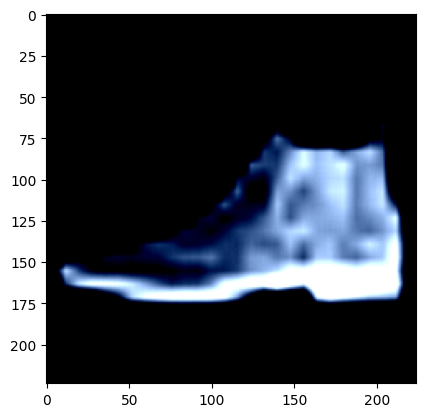

In [29]:
img = test_data[0][0]
image_np = img.permute(1, 2, 0).numpy()
plt.imshow(image_np)

### Transfer learning with ResNet18
**Loading the model**
* We load the pretrained ResNet18 model from torchvision. I tried with ResNet50, but there wasn't any significant improvement in accuracy, and it took almost twice as long, so I couldn't perform extensive hyperparameter tuning on that. 
* Default weights are set to the ones used in the paper by He et al. which first introduced ResNet.
* In the output, you can see the model layers. 
  
> Check `resnet50_metrics` directory for comparing ResNet50 and ResNet18 performance metrics.

In [30]:
device = torch.device("mps") # "cuda" for CUDA-GPUs, "cpu" for CPU, although training on CPU is not suggested
weights = torchvision.models.ResNet18_Weights.DEFAULT
model = torchvision.models.resnet18(weights=weights) # load model to device
model = model.to(device)


for name, layer in model.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


**Model modification**
* We freeze all layers initially (`requires_grad=False`), and build a new classification head with 10 output classes of Fashion-MNIST. 
* This way, the model can use learned features like edges, shapes etc. to classify the images, without requiring us to train the entire model (11.44 million parameters!). 
* A complex clasification head is used, which increases accuract by 2-3% compared to the default linear layer (commented). The dropout is tuned with trial and error.'

In [31]:
for param in model.parameters():
    param.requires_grad = False # freeze all layers

# model.fc = torch.nn.Linear(
#     in_features=model.fc.in_features,
#     out_features=len(class_names),
#     bias=True,
# )

model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.1),
    torch.nn.Linear(model.fc.in_features, 512),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.1),
    torch.nn.Linear(512, len(class_names)),
)

The following code snippet helps visualize the model arcitecture. You can scroll to the end to observe that only 267k parameters need to be trained, instead of 23 million. 

In [32]:
summary(model=model, 
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 10]             --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (36,864)             False
│    │    

**Optimizer**
* Adam optimizer is used with a learning rate of 3e-4 (the infamous Karpathy Learning Constant).
* Note that we skip frozen layers, otherwise the model will spend time to compute weights and biases for those layers, which will anyways not be updated as it is frozen. This considerably speeds up training.
* The `CrossEntropyLoss` function is most suitable for multi-class classification with mutually exclusive classes. After the softmax converts logits to probabilities, it penalizes the model for incorrect predictions (i.e.  not sure what the correct answer is). In a way, it is helping the model '**make up its mind**'.

In [33]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4)

loss_fn = torch.nn.CrossEntropyLoss()

**Training**
* The following code is quite long but straightforward. It essentially has 3 functions. `train_step`, `test_step` and `train`.
* The progress bar updates every epoch, however, I have included a percentage display that shows progress of each epoch. 
* However, it requires the IPython display module to be installed
* These functions are reused in the fine tuning phase as well
* Appropriate comments are included in the code itself

In [10]:
def train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()

    train_loss, train_acc = 0, 0
    num = 0
    den = len(dataloader)

    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        model, X, y = model.to(device), X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
        if num % 10 == 0:
            clear_output(wait=True)
            print(f"{round((batch/den)*100)}% train completed")
        num += 1

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


def test_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, device: torch.device) -> Tuple[float, float]:
    model.eval()

    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        num = 0
        den = len(dataloader)
        for batch, (X, y) in enumerate(dataloader):
            model, X, y = model.to(device), X.to(device), y.to(device)

            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)
            if num % 10 == 0:
                clear_output(wait=True)
                print(f"{round((batch/den)*100)}% test completed")
            num += 1

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device, ft=False):
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, device=device)
        test_loss, test_acc = test_step(model=model, dataloader=test_dataloader, loss_fn=loss_fn, device=device)

        print(f"Epoch: {epoch+1} | " f"train_loss: {train_loss:.4f} | " f"train_acc: {train_acc:.4f} | " f"test_loss: {test_loss:.4f} | " f"test_acc: {test_acc:.4f}")

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        # Save model state dict
        if ft:
            torch.save(model.state_dict(), f"ft_resnet18_{epoch}_model.pt")
        else:
            torch.save(model.state_dict(), f"resnet18_{epoch}_model.pt")

    # Return the filled results at the end of the epochs
    return results


**Training**
Now, we can train the model. On my device it took about 15 minutes for 8 epochs, with a batch size of 64. 

In [11]:
torch.manual_seed(42)

# Setup training and save the results
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=10,
                device=device)


96% test completed


100%|██████████| 10/10 [20:03<00:00, 120.37s/it]

Epoch: 10 | train_loss: 0.3365 | train_acc: 0.8751 | test_loss: 0.3398 | test_acc: 0.8743


### Evaluation
**Validation metrics**
The training and testing loss and accuracy are plotted for every epoch, to understand whether overfitting occured, if current number of epochs is sufficient etc.

{'train_loss': [0.5996538729651142, 0.4573173518024528, 0.43132772291901267, 0.40893425631211766, 0.39086592492899663, 0.3726486031498228, 0.36374125243631256, 0.3529223670233796, 0.3426706039511573, 0.3364820961536629], 'train_acc': [0.7959588219616205, 0.8357542643923241, 0.8435667643923241, 0.849680170575693, 0.8566930970149254, 0.8627232142857143, 0.8649720149253731, 0.8687366737739872, 0.8739838752665245, 0.8751499200426439], 'test_loss': [0.4316283683678147, 0.40927940142002833, 0.3870204865552817, 0.3716587915921667, 0.3563115471487592, 0.3505168508762007, 0.3378145521043972, 0.3365166353382123, 0.3280667746142977, 0.3397520532843414], 'test_acc': [0.8493232484076433, 0.8530055732484076, 0.8637539808917197, 0.8668391719745223, 0.872312898089172, 0.8733081210191083, 0.8751990445859873, 0.8771894904458599, 0.8823646496815286, 0.8743033439490446]}


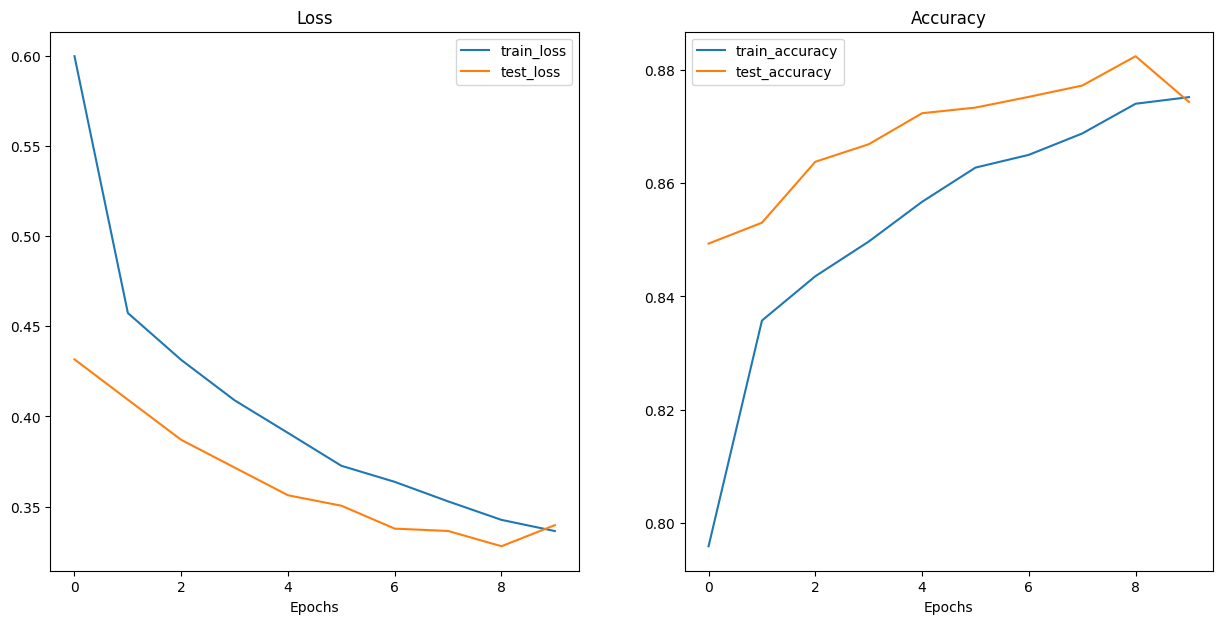

In [12]:
# Plot loss curves of a model
def plot_loss_curves(results):

    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

print(results)
plot_loss_curves(results)

**Performance**

Below you can see the class-wise accuracy, precision, recall and f1 score. You can also see the confusion matrix. All data is stored in `final_metrics` directory.

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== Model Evaluation Metrics ===
Accuracy: 0.8775
Precision (weighted): 0.8807
Recall (weighted): 0.8775
F1-Score (weighted): 0.8785

=== Detailed Classification Report ===
              precision    recall  f1-score   support

 T-shirt/top       0.87      0.80      0.83      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.84      0.80      0.82      1000
       Dress       0.86      0.86      0.86      1000
        Coat       0.78      0.83      0.80      1000
      Sandal       0.97      0.93      0.95      1000
       Shirt       0.66      0.72      0.69      1000
     Sneaker       0.91      0.95      0.93      1000
         Bag       0.98      0.96      0.97      1000
  Ankle boot       0.95      0.95      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



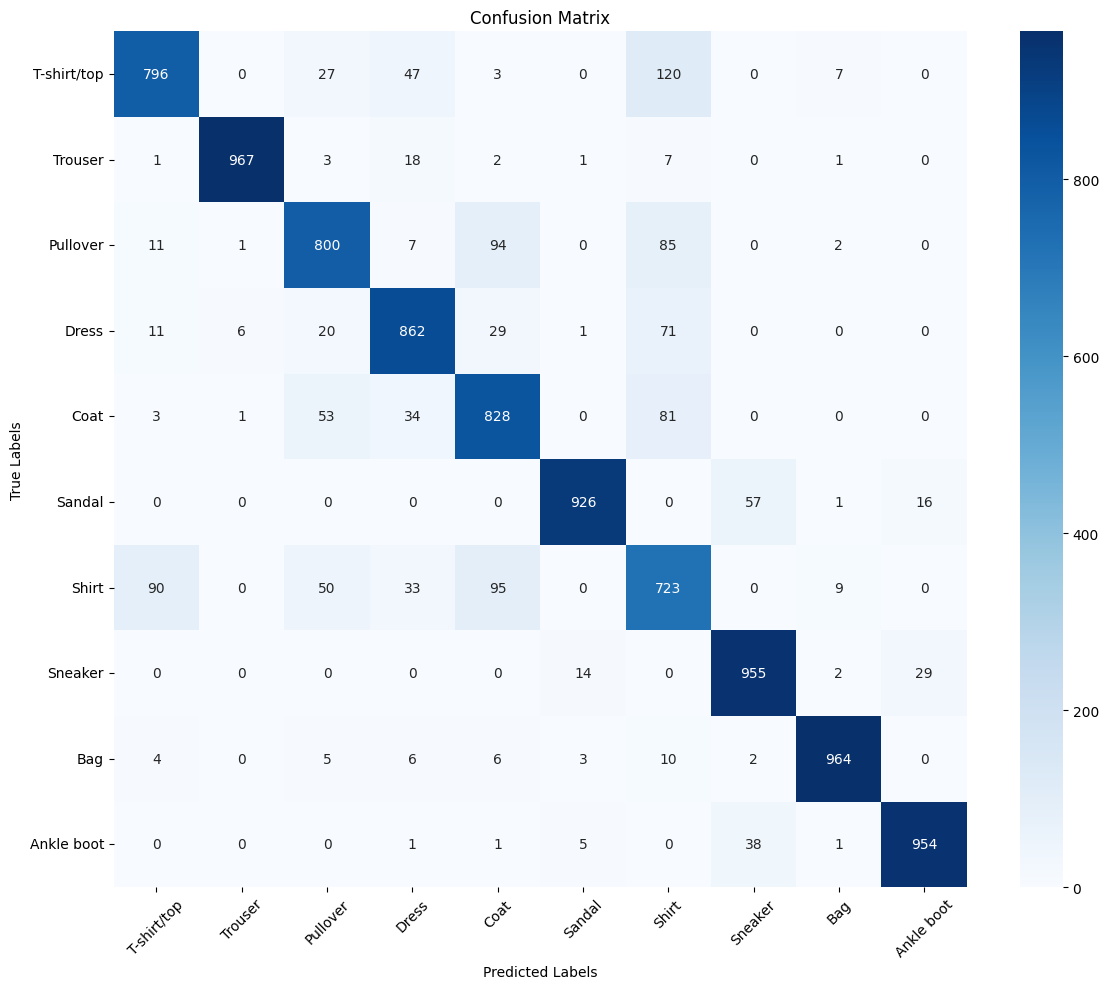


=== Per-Class Accuracy ===
T-shirt/top: 0.7960
Trouser: 0.9670
Pullover: 0.8000
Dress: 0.8620
Coat: 0.8280
Sandal: 0.9260
Shirt: 0.7230
Sneaker: 0.9550
Bag: 0.9640
Ankle boot: 0.9540

=== Files Saved ===
All evaluation metrics and plots saved to 'transfer_learning_final_metrics/' folder:
- evaluation_metrics.json: Overall metrics in JSON format
- classification_report.txt: Detailed text report
- confusion_matrix.png: Confusion matrix visualization
- confusion_matrix.csv: Confusion matrix data
- predictions.csv: All predictions vs actual labels


In [41]:

def get_metrics(model, test_dataloader, out_dir):
    os.makedirs(out_dir, exist_ok=True)

    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch, (X, y) in enumerate(test_dataloader):
            model, X, y = model.to(device), X.to(device), y.to(device)

            test_pred_logits = model(X)
            predicted_labels = torch.argmax(test_pred_logits, dim=1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(predicted_labels.cpu().numpy())

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("=== Model Evaluation Metrics ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print(f"F1-Score (weighted): {f1:.4f}")
    print("\n=== Detailed Classification Report ===")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()

    # Save confusion matrix plot
    plt.savefig(f'{out_dir}/confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Calculate per-class accuracy
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
    print("\n=== Per-Class Accuracy ===")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {per_class_accuracy[i]:.4f}")

    # Save evaluation metrics to JSON file
    metrics_dict = {
        'overall_metrics': {
            'accuracy': float(accuracy),
            'precision_weighted': float(precision),
            'recall_weighted': float(recall),
            'f1_score_weighted': float(f1)
        },
        'per_class_accuracy': {
            class_names[i]: float(per_class_accuracy[i]) for i in range(len(class_names))
        },
        'confusion_matrix': cm.tolist(),
        'class_names': class_names
    }

    with open(f'{out_dir}/evaluation_metrics.json', 'w') as f:
        json.dump(metrics_dict, f, indent=2)

    # Save detailed classification report to text file
    with open('final_metrics/classification_report.txt', 'w') as f:
        f.write("=== Model Evaluation Metrics ===\n")
        f.write(f"Accuracy: {accuracy:.4f}\n")
        f.write(f"Precision (weighted): {precision:.4f}\n")
        f.write(f"Recall (weighted): {recall:.4f}\n")
        f.write(f"F1-Score (weighted): {f1:.4f}\n\n")
        f.write("=== Detailed Classification Report ===\n")
        f.write(classification_report(y_true, y_pred, target_names=class_names))
        f.write("\n\n=== Per-Class Accuracy ===\n")
        for i, class_name in enumerate(class_names):
            f.write(f"{class_name}: {per_class_accuracy[i]:.4f}\n")

    # Save confusion matrix as CSV
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm_df.to_csv(f'{out_dir}/confusion_matrix.csv')

    # Save predictions vs actual labels
    predictions_df = pd.DataFrame({
        'actual': y_true,
        'predicted': y_pred,
        'actual_label': [class_names[i] for i in y_true],
        'predicted_label': [class_names[i] for i in y_pred]
    })
    predictions_df.to_csv(f'{out_dir}/predictions.csv', index=False)

    print(f"\n=== Files Saved ===")
    print(f"All evaluation metrics and plots saved to '{out_dir}/' folder:")
    print("- evaluation_metrics.json: Overall metrics in JSON format")
    print("- classification_report.txt: Detailed text report")
    print("- confusion_matrix.png: Confusion matrix visualization")
    print("- confusion_matrix.csv: Confusion matrix data")
    print("- predictions.csv: All predictions vs actual labels")

model.load_state_dict(torch.load(f'resnet18_7_model.pt'))
get_metrics(model, test_dataloader, 'transfer_learning_final_metrics')

### Fine-tuning
After training the classification head, we can unfreeze deeper layers of the model to fine-tune it further. This helps the model learn more specific features relevant to Fashion-MNIST.

* We begin by loading the best model from the previous training phase.
* We unfreeze the last 3 layers of the model by setting `requires_grad=True` for those layers.
* Then we fine tune it for 8 epochs with a lower learning rate to avoid drastic changes.
* You can see that the accuracy improves by 5-6% due to fine tuning.

96% test completed


100%|██████████| 8/8 [22:53<00:00, 171.73s/it]

Epoch: 8 | train_loss: 0.0198 | train_acc: 0.9928 | test_loss: 0.3041 | test_acc: 0.9340


=== Model Evaluation Metrics ===
Accuracy: 0.9337
Precision (weighted): 0.9338
Recall (weighted): 0.9337
F1-Score (weighted): 0.9336

=== Detailed Classification Report ===
              precision    recall  f1-score   support

 T-shirt/top       0.87      0.89      0.88      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.93      0.88      0.91      1000
       Dress       0.94      0.93      0.93      1000
        Coat       0.88      0.93      0.91      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.82      0.79      0.81      1000
     Sneaker       0.97      0.98      0.97      1000
         Bag       0.98      0.99      0.98      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



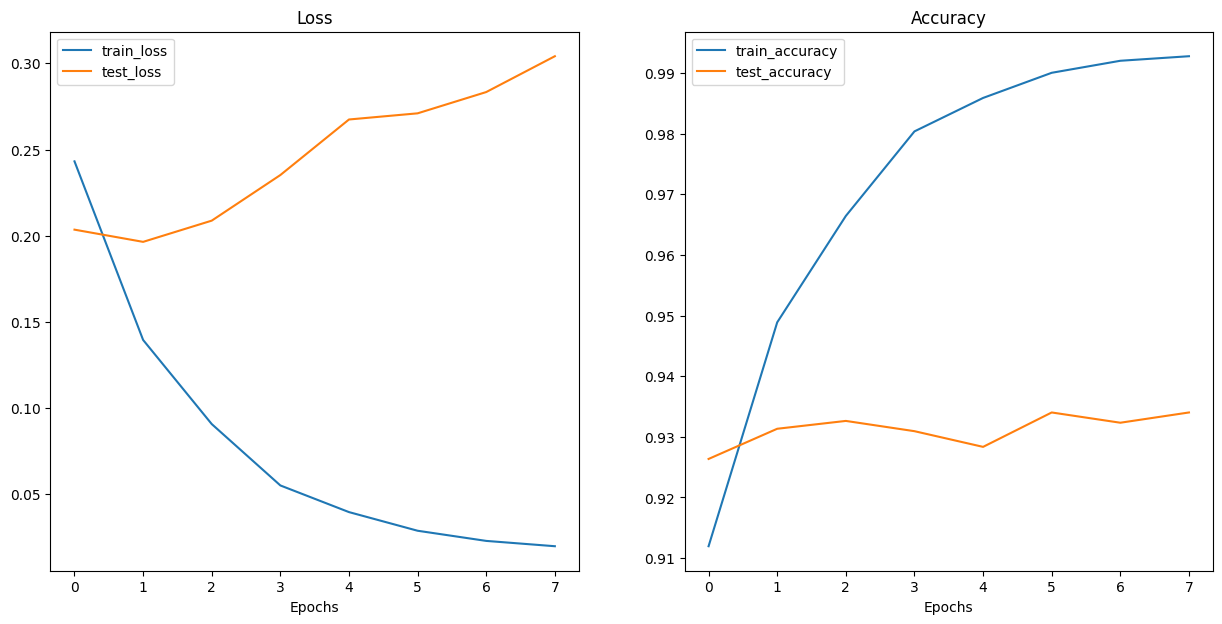

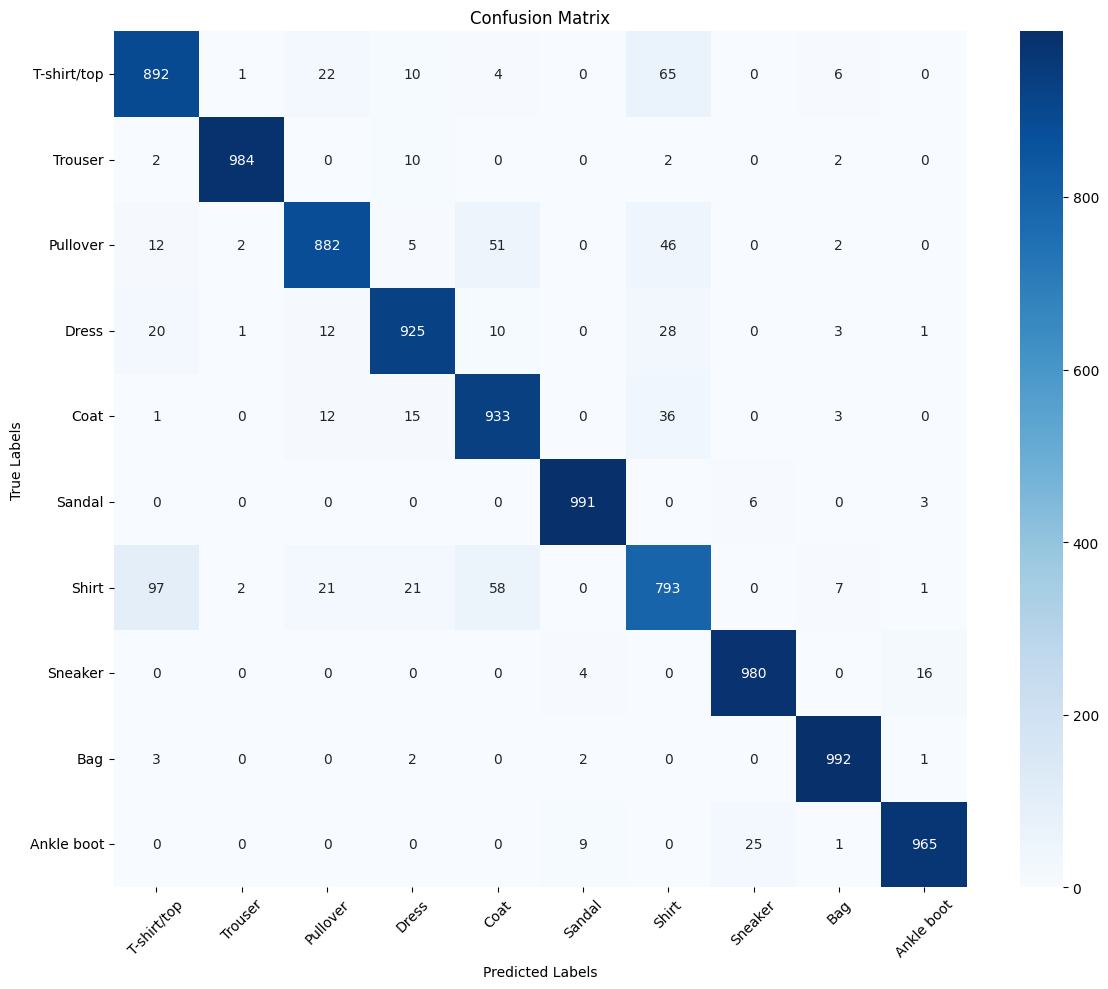


=== Per-Class Accuracy ===
T-shirt/top: 0.8920
Trouser: 0.9840
Pullover: 0.8820
Dress: 0.9250
Coat: 0.9330
Sandal: 0.9910
Shirt: 0.7930
Sneaker: 0.9800
Bag: 0.9920
Ankle boot: 0.9650

=== Files Saved ===
All evaluation metrics and plots saved to 'fine_tuning_final_metrics/' folder:
- evaluation_metrics.json: Overall metrics in JSON format
- classification_report.txt: Detailed text report
- confusion_matrix.png: Confusion matrix visualization
- confusion_matrix.csv: Confusion matrix data
- predictions.csv: All predictions vs actual labels


In [ ]:
train_data = datasets.FashionMNIST('../Fashion-MNIST', transform=manual_transforms, train=True)
test_data = datasets.FashionMNIST('../Fashion-MNIST', transform=manual_transforms, train=False)
class_names = train_data.classes

train_dataloader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
)
test_dataloader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False, # don't need to shuffle test data
    num_workers=num_workers,
    pin_memory=True,
)

device = torch.device("mps")
weights = torchvision.models.ResNet18_Weights.DEFAULT
model = torchvision.models.resnet18(weights=weights) # load model to device
model = model.to(device)

model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.1),
    torch.nn.Linear(model.fc.in_features, 512),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.1),
    torch.nn.Linear(512, len(class_names)),
)

model.load_state_dict(torch.load('resnet18_7_model.pt')) # load weights

for name, layer in model.named_children():
    if name in ['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2']:
        for param in layer.parameters():
            param.requires_grad = False

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss()

results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=8,
                device=device,
                ft=True)

plot_loss_curves(results)
get_metrics(model, test_dataloader, 'fine_tuning_final_metrics')